# CNN 2D para Detección de Parkinson (Baseline con Augmentation + Talos)
## Baseline Model - Train/Val/Test Split + Hyperparameter Optimization

Este notebook entrena un modelo **CNN2D simple** (sin Domain Adaptation) para clasificación binaria Parkinson vs Healthy **usando data augmentation** y **optimización automática de hiperparámetros con Talos**.

### Pipeline:
1. **Setup**: Configuración del entorno
2. **Data Loading**: Carga de datos CON augmentation
3. **Split**: Train/Val/Test estratificado (70/15/15)
4. **Talos Optimization**: Optimización automática de hiperparámetros (20 configuraciones)
5. **Final Training**: Re-entrenamiento con mejores hiperparámetros + early stopping
6. **Evaluation**: Métricas completas en test set
7. **Visualization**: Gráficas de progreso y resultados

### Arquitectura:
Este modelo usa el **mismo Feature Extractor** que CNN2D_DA (arquitectura Ibarra 2023) pero **sin Domain Adaptation**:
- 2 bloques Conv2D → BN → ReLU → MaxPool(3×3) → Dropout
- Solo cabeza de clasificación PD (sin GRL ni cabeza de dominio)

### Data Augmentation:
- Pitch shifting
- Time stretching
- Noise injection
- SpecAugment (máscaras de frecuencia/tiempo)
- Factor: ~5x más datos

### Comparación:
- **Este notebook**: Modelo CNN2D con augmentation (mejora generalización)
- **cnn_da_training.ipynb**: Modelo CNN2D_DA sin augmentation (paper exacto)
- El augmentation permite entrenar con más datos y mejorar robustez


In [ ]:
# ============================================================
# CONFIGURACIÓN PARA GOOGLE COLAB
# ============================================================
# Descomenta estas líneas si ejecutas este notebook en Colab

from modules.core.notebook_setup import setup_colab_git

project_path = setup_colab_git(
    computer_name="ZenBook",
    project_dir="parkinson-voice-uncertainty",
    branch="feature/feature/firstTraining"
)
# ============================================================


In [ ]:
# ============================================================
# CONFIGURAR ENTORNO Y DEPENDENCIAS
# ============================================================

import sys
from pathlib import Path

# Agregar el directorio raíz del proyecto al path
# El notebook está en research/, pero modules/ está en el directorio raíz
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Importar el gestor de dependencias centralizado
from modules.core.dependency_manager import setup_notebook_environment

# Configurar el entorno automáticamente
# Esto verifica e instala todas las dependencias necesarias
success = setup_notebook_environment(auto_install=True, verbose=True)

if not success:
    print("Error configurando el entorno")
    print("Intenta instalar manualmente: pip install -r requirements.txt")
    import sys
    sys.exit(1)

print("="*70)


🚀 Configurando entorno para notebook...
🔍 Información del entorno:
   python_version: 3.10.3 (tags/v3.10.3:a342a49, Mar 16 2022, 13:07:40) [MSC v.1929 64 bit (AMD64)]
   platform: win32
   is_colab: False
   is_jupyter: True
   working_directory: c:\Proyectos\PHD- Parkinson - Incertidumbre - Prototipo\parkinson-voice-uncertainty\research
   torch_version: 2.8.0+cpu
   cuda_available: False
❌ Talos - talos
🔍 Estado de dependencias:
   ✅ PyTorch
   ✅ TorchVision
   ✅ NumPy
   ✅ Pandas
   ✅ Scikit-learn
   ✅ Matplotlib
   ✅ Seaborn
   ✅ Librosa
   ✅ SoundFile
   ✅ Jupyter
   ❌ Talos - talos

🔧 Instalando 1 dependencias faltantes...
🔧 GESTIÓN DE DEPENDENCIAS - PARKINSON VOICE UNCERTAINTY
❌ Talos - talos
🔍 Estado de dependencias:
   ✅ PyTorch
   ✅ TorchVision
   ✅ NumPy
   ✅ Pandas
   ✅ Scikit-learn
   ✅ Matplotlib
   ✅ Seaborn
   ✅ Librosa
   ✅ SoundFile
   ✅ Jupyter
   ❌ Talos - talos

🔍 Entorno: Local

🚀 Instalando 1 dependencias faltantes...
❌ requirements.txt no encontrado
⚠️  Falló in

SystemExit: 1

In [ ]:
# ============================================================
# CONFIGURACIÓN COMPLETA DEL EXPERIMENTO (PAPER IBARRA 2023)
# ============================================================

print("="*70)
print("CONFIGURACIÓN DEL EXPERIMENTO - PAPER IBARRA 2023")
print("="*70)

# ============================================================
# CONFIGURACIÓN DEL OPTIMIZADOR (SGD como en el paper)
# ============================================================
OPTIMIZER_CONFIG = {
    "type": "SGD",
    "learning_rate": 0.1,
    "momentum": 0.9,
    "weight_decay": 0.0
}

# ============================================================
# CONFIGURACIÓN DEL SCHEDULER (StepLR como en el paper)
# ============================================================
SCHEDULER_CONFIG = {
    "type": "StepLR",
    "step_size": 10,
    "gamma": 0.1
}

# ============================================================
# CONFIGURACIÓN DEL K-FOLD CROSS-VALIDATION
# ============================================================
KFOLD_CONFIG = {
    "n_splits": 10,
    "shuffle": True,
    "random_state": 42,
    "stratify_by_speaker": True
}

# ============================================================
# CONFIGURACIÓN DE CLASS WEIGHTS (para balancear clases)
# ============================================================
CLASS_WEIGHTS_CONFIG = {
    "enabled": True,
    "method": "inverse_frequency"  # 1/frequency
}

# ============================================================
# CONFIGURACIÓN DE FILTRADO DE VOCAL /a/
# ============================================================
VOCAL_FILTER_CONFIG = {
    "enabled": True,
    "target_vocal": "a",  # Solo vocal /a/ como en el paper
    "filter_healthy": True,
    "filter_parkinson": True
}

# ============================================================
# CONFIGURACIÓN DE ENTRENAMIENTO
# ============================================================
TRAINING_CONFIG = {
    "n_epochs": 100,
    "early_stopping_patience": 15,
    "batch_size": 32,
    "num_workers": 0,
    "save_best_model": True
}

# ============================================================
# CONFIGURACIÓN DE TALOS (OPTIMIZACIÓN DE HIPERPARÁMETROS)
# ============================================================
TALOS_CONFIG = {
    "enabled": True,
    "experiment_name": "cnn2d_talos_optimization",
    "search_method": "random",
    "fraction_limit": 0.3,
    "n_epochs": 20,  # Épocas por configuración (búsqueda rápida)
    "metric": "f1"
}

# ============================================================
# CONFIGURACIÓN DE DATOS
# ============================================================
DATA_CONFIG = {
    "test_size": 0.15,
    "val_size": 0.15,
    "random_state": 42,
    "stratify": True
}


CONFIGURACIÓN DEL EXPERIMENTO - PAPER IBARRA 2023


## 1. Setup y Configuración


In [ ]:
# ============================================================
# IMPORTS Y CONFIGURACIÓN
# ============================================================
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import json
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Agregar módulos propios al path
# El notebook está en research/, pero modules/ está en el directorio raíz
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Importar módulos propios
from modules.models.cnn2d.model import CNN2D
from modules.models.common.training_utils import print_model_summary
from modules.models.cnn2d.training import train_model, detailed_evaluation, print_evaluation_report
from modules.models.cnn2d.visualization import plot_training_history, analyze_spectrogram_stats
from modules.models.cnn2d.utils import plot_confusion_matrix
from modules.core.dataset import (
    load_spectrograms_cache,
    to_pytorch_tensors,
    DictDataset,
)


# Imports para Talos (optimización de hiperparámetros)
from modules.core.cnn2d_talos_wrapper import optimize_cnn2d

# Configuración de matplotlib
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Configuración de PyTorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Reporte de configuración
print("="*70)
print("CNN 2D TRAINING - BASELINE CON AUGMENTATION")
print("="*70)
print(f"Librerías cargadas correctamente")
print(f"Dispositivo: {device}")
print(f"PyTorch: {torch.__version__}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"Data augmentation: ACTIVADO (~5x datos)")
print("="*70)


CNN 2D TRAINING - BASELINE CON AUGMENTATION
Librerías cargadas correctamente
Dispositivo: cpu
PyTorch: 2.8.0+cpu
Data augmentation: ACTIVADO (~5x datos)


## 2. Carga de Datos con Augmentation

Carga de datos preprocesados CON augmentation para mejorar generalización del modelo baseline.


In [ ]:
# ============================================================
# CARGAR DATOS HEALTHY DESDE CACHE ORIGINAL
# ============================================================

print("Cargando datos Healthy desde cache original...")
print("="*60)


# Cargar datos healthy desde cache original
cache_healthy_path = "./cache/original/healthy_ibarra.pkl"
healthy_dataset = load_spectrograms_cache(cache_healthy_path)

if healthy_dataset is None:
    raise FileNotFoundError(f"No se encontró el cache de datos healthy en {cache_healthy_path}")

# Convertir a tensores PyTorch
X_healthy, y_task_healthy, y_domain_healthy, meta_healthy = to_pytorch_tensors(healthy_dataset)

print(f"Healthy cargado exitosamente:")
print(f"   - Espectrogramas: {X_healthy.shape[0]}")
print(f"   - Shape: {X_healthy.shape}")


Cargando datos Healthy desde cache original...


FileNotFoundError: No se encontró el cache de datos healthy en ./cache/original/healthy_ibarra.pkl

In [ ]:
# ============================================================
# INFORMACIÓN DE DATOS CARGADOS
# ============================================================

print("="*70)
print("INFORMACIÓN DE DATOS CARGADOS")
print("="*70)

print(f"Datos Healthy (desde cache original):")
print(f"   - Muestras: {len(healthy_dataset)}")
print(f"   - Shape de espectrogramas: {X_healthy.shape}")

print("\nConfiguración:")
print("   - Healthy: datos originales sin augmentation")
print("   - Parkinson: datos con SpecAugment para mejorar generalización")
print("="*70)


INFORMACIÓN DE DATOS CARGADOS
Datos Healthy (desde cache original):
   - Muestras: 155
   - Shape de espectrogramas: torch.Size([155, 1, 65, 41])

Datos Parkinson (desde cache augmentado):
   - Muestras: 363
   - Shape de espectrogramas: torch.Size([363, 1, 65, 41])

Configuración:
   - Healthy: datos originales sin augmentation
   - Parkinson: datos con SpecAugment para mejorar generalización


In [ ]:
# ============================================================
# ANÁLISIS ESTADÍSTICO BÁSICO
# ============================================================

print("="*70)
print("ANÁLISIS ESTADÍSTICO BÁSICO")
print("="*70)

# Análisis estadístico básico
healthy_stats = analyze_spectrogram_stats(healthy_dataset, "HEALTHY")
parkinson_stats = analyze_spectrogram_stats(parkinson_dataset, "PARKINSON")

# Comparar diferencias
print(f"\nDIFERENCIAS ENTRE CLASES:")
print(f"   - Diferencia en media: {abs(healthy_stats['mean'] - parkinson_stats['mean']):.3f}")
print(f"   - Diferencia en std: {abs(healthy_stats['std'] - parkinson_stats['std']):.3f}")

print("\nConfiguración del experimento:")
print("   - Healthy: datos originales (baseline)")
print("   - Parkinson: datos con augmentation (mejor generalización)")
print("="*70)


ANÁLISIS ESTADÍSTICO BÁSICO

HEALTHY:
   • Número de espectrogramas: 155
   • Shape típico: (65, 41)
   • Media: -0.000
   • Desviación estándar: 1.000
   • Min: -2.289
   • Max: 7.561

PARKINSON:
   • Número de espectrogramas: 363
   • Shape típico: (65, 41)
   • Media: 0.002
   • Desviación estándar: 0.946
   • Min: -2.893
   • Max: 8.277

DIFERENCIAS ENTRE CLASES:
   - Diferencia en media: 0.002
   - Diferencia en std: 0.054

Configuración del experimento:
   - Healthy: datos originales (baseline)
   - Parkinson: datos con augmentation (mejor generalización)


## 3. Split Train/Val/Test

Split estratificado 70/15/15 para mantener proporciones de clases.


In [ ]:
# ============================================================
# 10-FOLD CROSS-VALIDATION ESTRATIFICADO POR HABLANTE
# ============================================================

print("="*70)
print("10-FOLD CROSS-VALIDATION (PAPER IBARRA 2023)")
print("="*70)

# 10-Fold Cross-Validation estratificado por hablante (como en el paper Ibarra 2023)


# Obtener speaker IDs para estratificación
# Crear speaker IDs basados en los datasets originales
speaker_ids = []

# Para healthy dataset (asumiendo que cada speaker tiene ~10 muestras)
for i in range(len(X_healthy)):
    speaker_id = f"healthy_{i//10}"  # Agrupar por speaker
    speaker_ids.append(speaker_id)

# Para parkinson dataset
for i in range(len(X_parkinson)):
    speaker_id = f"parkinson_{i//10}"  # Agrupar por speaker
    speaker_ids.append(speaker_id)

speaker_ids = np.array(speaker_ids)
unique_speakers = np.unique(speaker_ids)

print(f" Dataset info:")
print(f"   • Total samples: {len(X_combined)}")
print(f"   • Unique speakers: {len(unique_speakers)}")
print(f"   • Samples per speaker: {len(X_combined) // len(unique_speakers)}")

# Crear K-Fold estratificado por speaker usando configuración centralizada
kfold = StratifiedKFold(
    n_splits=KFOLD_CONFIG["n_splits"],
    shuffle=KFOLD_CONFIG["shuffle"],
    random_state=KFOLD_CONFIG["random_state"]
)

# Para este notebook, usaremos el primer fold como ejemplo
# En el paper real se promedian los resultados de los 10 folds
fold_splits = list(kfold.split(X_combined, speaker_ids))
train_idx, val_idx = fold_splits[0]  # Primer fold

X_train = X_combined[train_idx]
y_train = y_combined[train_idx]
X_val = X_combined[val_idx]
y_val = y_combined[val_idx]

# Para test, usamos un split separado del 15%
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_combined, y_combined,
    test_size=0.15,
    random_state=42,
    stratify=y_combined
)

print(f"\nTAMAÑOS DE SPLITS:")
print(f"   - Train: {len(X_train)} ({len(X_train)/len(X_combined)*100:.1f}%)")
print(f"   - Val:   {len(X_val)} ({len(X_val)/len(X_combined)*100:.1f}%)")
print(f"   - Test:  {len(X_test)} ({len(X_test)/len(X_combined)*100:.1f}%)")

print(f"\nDISTRIBUCIÓN POR SPLIT:")
for split_name, y_split in [("Train", y_train), ("Val", y_val), ("Test", y_test)]:
    n_healthy = (y_split == 0).sum().item()
    n_parkinson = (y_split == 1).sum().item()
    print(f"   {split_name:5s}: HC={n_healthy:4d} ({n_healthy/len(y_split)*100:.1f}%), PD={n_parkinson:4d} ({n_parkinson/len(y_split)*100:.1f}%)")

print("="*70)


SPLIT TRAIN/VAL/TEST

TAMAÑOS DE SPLITS:
   - Train: 362 (69.9%)
   - Val:   78 (15.1%)
   - Test:  78 (15.1%)

DISTRIBUCIÓN POR SPLIT:
   Train: HC= 109 (30.1%), PD= 253 (69.9%)
   Val  : HC=  23 (29.5%), PD=  55 (70.5%)
   Test : HC=  23 (29.5%), PD=  55 (70.5%)


In [ ]:
# Agregar módulos propios al path
# El notebook está en research/, pero modules/ está en el directorio raíz
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# ============================================================
# CREAR DATALOADERS
# ============================================================

print("\n📦 CREANDO DATALOADERS...")

BATCH_SIZE = 32

# Importar DictDataset desde el módulo core

# Crear datasets con formato de diccionario
train_dataset = DictDataset(X_train, y_train)
val_dataset = DictDataset(X_val, y_val)
test_dataset = DictDataset(X_test, y_test)

# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=0)

print(f"✅ DataLoaders creados:")
print(f"   • Train batches: {len(train_loader)}")
print(f"   • Val batches:   {len(val_loader)}")
print(f"   • Test batches:  {len(test_loader)}")
print(f"   • Batch size:    {BATCH_SIZE}")



📦 CREANDO DATALOADERS...
✅ DataLoaders creados:
   • Train batches: 12
   • Val batches:   2
   • Test batches:  2
   • Batch size:    32


## 4. Optimización de Hiperparámetros con Talos

Optimización automática de hiperparámetros usando Talos para encontrar la mejor configuración del modelo CNN2D.

### Configuración:
- **Método**: Talos con búsqueda aleatoria
- **Configuraciones**: 30% de todas las combinaciones posibles
- **Épocas por config**: 20 épocas (búsqueda rápida)
- **Métrica**: F1-score en validación
- **Espacio de búsqueda**: Según tabla del paper


In [ ]:
# ============================================================
# CONFIGURAR OPTIMIZACIÓN CON TALOS
# ============================================================

print("="*70)
print("CONFIGURANDO OPTIMIZACIÓN CON TALOS")
print("="*70)

# Crear directorio para resultados de Talos
talos_results_dir = Path("./results/cnn_talos_optimization")
talos_results_dir.mkdir(parents=True, exist_ok=True)

print(f"✅ Módulos de Talos importados")
print(f"📁 Directorio de resultados: {talos_results_dir}")
print("="*70)


In [ ]:
# ============================================================
# PREPARAR DATOS PARA TALOS
# ============================================================

print("="*70)
print("PREPARANDO DATOS PARA TALOS")
print("="*70)

# Convertir datos a formato numpy (requerido por Talos)
X_train_np = X_train.numpy()
y_train_np = y_train.numpy()
X_val_np = X_val.numpy()
y_val_np = y_val.numpy()

print(f"📊 Datos preparados para Talos:")
print(f"   - Train: {X_train_np.shape} (labels: {y_train_np.shape})")
print(f"   - Val:   {X_val_np.shape} (labels: {y_val_np.shape})")
print(f"   - Test:  {X_test.shape} (labels: {y_test.shape})")

# Verificar distribución de clases
print(f"\n📈 Distribución de clases:")
print(f"   Train - HC: {(y_train_np == 0).sum()}, PD: {(y_train_np == 1).sum()}")
print(f"   Val   - HC: {(y_val_np == 0).sum()}, PD: {(y_val_np == 1).sum()}")

print("="*70)


In [ ]:
# ============================================================
# VERIFICAR SI YA EXISTEN RESULTADOS DE TALOS
# ============================================================

print("="*70)
print("VERIFICANDO RESULTADOS PREVIOS DE TALOS")
print("="*70)

# Configuración de la optimización usando configuración centralizada
# (TALOS_CONFIG ya está definido en la configuración centralizada)

# Verificar si ya existen resultados previos
results_csv_path = talos_results_dir / "talos_scan_results.csv"
best_params_path = talos_results_dir / "best_params.json"

if results_csv_path.exists() and best_params_path.exists():
    print("✅ Se encontraron resultados previos de Talos")
    print(f"   - Archivo de resultados: {results_csv_path}")
    print(f"   - Archivo de mejores parámetros: {best_params_path}")

    # Cargar resultados previos
    results_df = pd.read_csv(results_csv_path)
    with open(best_params_path, 'r') as f:
        best_params = json.load(f)

    print(f"\n📊 Resultados previos encontrados:")
    print(f"   - Total configuraciones evaluadas: {len(results_df)}")
    print(f"   - Mejor F1-score encontrado: {results_df['f1'].max():.4f}")
    print(f"   - F1-score promedio: {results_df['f1'].mean():.4f} ± {results_df['f1'].std():.4f}")

    print(f"\n🏆 Mejores hiperparámetros encontrados:")
    for param, value in best_params.items():
        if param not in ['f1', 'accuracy', 'precision', 'recall', 'val_loss', 'train_loss']:
            print(f"   - {param}: {value}")

    # Crear diccionario de resultados para compatibilidad
    talos_results = {
        "results_df": results_df,
        "best_params": best_params,
        "analysis": {"correlations": {}, "sorted_importance": [], "top_important": []}
    }

    print(f"\n⏭️  Saltando optimización - usando resultados previos")
    print("="*70)

else:
    print("❌ No se encontraron resultados previos de Talos")
    print("   - Iniciando optimización desde cero")

    print(f"\n⚙️  Configuración:")
    print(f"   - Método de búsqueda: {TALOS_CONFIG['search_method']}")
    print(f"   - Fracción a evaluar: {TALOS_CONFIG['fraction_limit']*100:.0f}%")
    print(f"   - Épocas por configuración: {TALOS_CONFIG['n_epochs']}")
    print(f"   - Métrica de optimización: F1-score")

    print(f"\n🚀 Iniciando búsqueda de hiperparámetros...")
    print("   (Esto puede tomar varios minutos)")

    # Ejecutar optimización
    talos_results = optimize_cnn2d(
        X_train=X_train_np,
        y_train=y_train_np,
        X_val=X_val_np,
        y_val=y_val_np,
        experiment_name=TALOS_CONFIG["experiment_name"],
        fraction_limit=TALOS_CONFIG["fraction_limit"],
        search_method=TALOS_CONFIG["search_method"],
        n_epochs=TALOS_CONFIG["n_epochs"]
    )

    print("="*70)
    print("OPTIMIZACIÓN COMPLETADA")
    print("="*70)


In [ ]:
# ============================================================
# ANÁLISIS DE RESULTADOS DE TALOS
# ============================================================

print("="*70)
print("ANÁLISIS DE RESULTADOS")
print("="*70)

# Extraer resultados
results_df = talos_results["results_df"]
best_params = talos_results["best_params"]
analysis = talos_results["analysis"]

print(f"📊 Resumen de la optimización:")
print(f"   - Total configuraciones evaluadas: {len(results_df)}")
print(f"   - Mejor F1-score encontrado: {results_df['f1'].max():.4f}")
print(f"   - F1-score promedio: {results_df['f1'].mean():.4f} ± {results_df['f1'].std():.4f}")

print(f"\n🏆 Mejores hiperparámetros encontrados:")
for param, value in best_params.items():
    if param not in ['f1', 'accuracy', 'precision', 'recall', 'val_loss', 'train_loss']:
        print(f"   - {param}: {value}")

# Mostrar top 10 configuraciones
print(f"\n📈 Top 10 configuraciones:")
print("-" * 80)
top_10 = results_df.nlargest(10, 'f1')
for i, (idx, row) in enumerate(top_10.iterrows(), 1):
    print(f"{i:2d}. F1: {row['f1']:.4f} | "
          f"Acc: {row['accuracy']:.4f} | "
          f"Batch: {row['batch_size']} | "
          f"LR: {row['learning_rate']} | "
          f"Dropout: {row['p_drop_conv']}")

print("="*70)


In [ ]:
# ============================================================
# GUARDAR RESULTADOS DE TALOS
# ============================================================

print("="*70)
print("GUARDANDO RESULTADOS DE TALOS")
print("="*70)

# Guardar DataFrame completo con todas las configuraciones
results_csv_path = talos_results_dir / "talos_scan_results.csv"
results_df.to_csv(results_csv_path, index=False)
print(f"💾 Resultados completos guardados: {results_csv_path}")

# Guardar mejores parámetros
best_params_path = talos_results_dir / "best_params.json"
with open(best_params_path, 'w') as f:
    json.dump(best_params, f, indent=2)
print(f"💾 Mejores parámetros guardados: {best_params_path}")

# Guardar resumen de optimización
summary_path = talos_results_dir / "optimization_summary.txt"
with open(summary_path, 'w') as f:
    f.write("RESUMEN DE OPTIMIZACIÓN TALOS\n")
    f.write("="*50 + "\n\n")
    f.write(f"Total configuraciones evaluadas: {len(results_df)}\n")
    f.write(f"Mejor F1-score: {results_df['f1'].max():.4f}\n")
    f.write(f"F1-score promedio: {results_df['f1'].mean():.4f} ± {results_df['f1'].std():.4f}\n\n")
    f.write("MEJORES HIPERPARÁMETROS:\n")
    f.write("-"*30 + "\n")
    for param, value in best_params.items():
        if param not in ['f1', 'accuracy', 'precision', 'recall', 'val_loss', 'train_loss']:
            f.write(f"{param}: {value}\n")
    f.write("\nTOP 5 CONFIGURACIONES:\n")
    f.write("-"*30 + "\n")
    top_5 = results_df.nlargest(5, 'f1')
    for i, (idx, row) in enumerate(top_5.iterrows(), 1):
        f.write(f"{i}. F1: {row['f1']:.4f} | Acc: {row['accuracy']:.4f} | "
                f"Batch: {row['batch_size']} | LR: {row['learning_rate']}\n")

print(f"💾 Resumen guardado: {summary_path}")

print("="*70)


In [ ]:
# Agregar módulos propios al path
# El notebook está en research/, pero modules/ está en el directorio raíz
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# ============================================================
# EVALUAR RESULTADOS DE TALOS
# ============================================================

print("="*70)
print("EVALUACIÓN DE RESULTADOS DE TALOS")
print("="*70)

# Importar evaluador

# Evaluar el proceso de optimización
evaluation = check_talos_results(str(talos_results_dir))

print("="*70)


## 5. Re-entrenamiento con Mejores Hiperparámetros

Re-entrenar el modelo CNN2D usando los mejores hiperparámetros encontrados por Talos, con early stopping para obtener el modelo final optimizado.


In [ ]:
# ============================================================
# CREAR MODELO CON MEJORES HIPERPARÁMETROS
# ============================================================

print("="*70)
print("CREANDO MODELO CON MEJORES HIPERPARÁMETROS")
print("="*70)

# Crear modelo con mejores parámetros encontrados por Talos
best_model = CNN2D(
    n_classes=2,
    p_drop_conv=best_params["p_drop_conv"],
    p_drop_fc=best_params["p_drop_fc"],
    input_shape=(65, 41),
    filters_1=best_params["filters_1"],
    filters_2=best_params["filters_2"],
    kernel_size_1=best_params["kernel_size_1"],
    kernel_size_2=best_params["kernel_size_2"],
    dense_units=best_params["dense_units"],
).to(device)

print(f"✅ Modelo creado con mejores hiperparámetros:")
print(f"   - Filters 1: {best_params['filters_1']}")
print(f"   - Filters 2: {best_params['filters_2']}")
print(f"   - Kernel 1: {best_params['kernel_size_1']}")
print(f"   - Kernel 2: {best_params['kernel_size_2']}")
print(f"   - Dense units: {best_params['dense_units']}")
print(f"   - Dropout conv: {best_params['p_drop_conv']}")
print(f"   - Dropout fc: {best_params['p_drop_fc']}")

# Mostrar arquitectura
print_model_summary(best_model)

print("="*70)


In [ ]:
# ============================================================
# CONFIGURAR ENTRENAMIENTO CON MEJORES PARÁMETROS
# ============================================================

print("="*70)
print("CONFIGURANDO ENTRENAMIENTO FINAL")
print("="*70)

# Configuración de entrenamiento final usando configuración centralizada
FINAL_TRAINING_CONFIG = {
    "n_epochs": 100,
    "early_stopping_patience": 15,
    "learning_rate": 0.1,
    "batch_size": best_params["batch_size"]
}

# Crear DataLoaders con el mejor batch size
train_loader_final = DataLoader(
    train_dataset,
    32,  # batch_size
    shuffle=True,
    num_workers=0
)
val_loader_final = DataLoader(
    val_dataset,
    32,  # batch_size
    shuffle=False,
    num_workers=0
)
test_loader_final = DataLoader(
    test_dataset,
    32,  # batch_size
    shuffle=False,
    num_workers=0
)

# Optimizador SGD con momentum usando configuración centralizada
optimizer_final = optim.SGD(
    best_model.parameters(),
    0.1,  # learning_rate
    0.9,  # momentum
    0.0,  # weight_decay
)

# Calcular class weights para balancear las clases usando configuración centralizada
    True,  # class_weights_enabled
    class_counts = torch.bincount(y_train)
    class_weights = 1.0 / class_counts.float()
    class_weights = class_weights / class_weights.sum()
    criterion_final = nn.CrossEntropyLoss(weight=class_weights.to(device))
    print(f"✅ Class weights habilitados: {class_weights.tolist()}")
else:
    criterion_final = nn.CrossEntropyLoss()
    print("⚠️  Class weights deshabilitados")

# Scheduler StepLR usando configuración centralizada
scheduler_final = torch.optim.lr_scheduler.StepLR(
    optimizer_final,
    30,  # step_size
    0.1,  # gamma
)

print(f"⚙️  Configuración final:")
print(f"   - Learning rate inicial: {FINAL_TRAINING_CONFIG['learning_rate']}")
print(f"   - Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)")
print(f"   - Batch size: {FINAL_TRAINING_CONFIG['batch_size']}")
print(f"   - Épocas máximas: {FINAL_TRAINING_CONFIG['n_epochs']}")
print(f"   - Early stopping patience: {FINAL_TRAINING_CONFIG['early_stopping_patience']}")

print("="*70)


In [ ]:
# ============================================================
# ENTRENAR MODELO FINAL CON EARLY STOPPING
# ============================================================

print("="*70)
print("ENTRENANDO MODELO FINAL")
print("="*70)

# Entrenar modelo con mejores hiperparámetros
final_training_results = train_model(
    model=best_model,
    train_loader=train_loader_final,
    val_loader=val_loader_final,
    optimizer=optimizer_final,
    criterion=criterion_final,
    device=device,
    100,  # n_epochs
    15,  # early_stopping_patience
    save_dir=talos_results_dir,
    verbose=True,
    scheduler=scheduler_final  # Pasar scheduler para ajuste automático de LR
)

# Extraer resultados
final_model = final_training_results["model"]
final_history = final_training_results["history"]
final_best_val_loss = final_training_results["best_val_loss"]
final_total_time = final_training_results["total_time"]

# Calcular mejor época
final_best_epoch = final_history["val_loss"].index(min(final_history["val_loss"])) + 1

print("="*70)
print("ENTRENAMIENTO FINAL COMPLETADO")
print("="*70)
print(f"✅ Resultados:")
print(f"   - Mejor época: {final_best_epoch}")
print(f"   - Mejor val loss: {final_best_val_loss:.4f}")
print(f"   - Tiempo total: {final_total_time/60:.1f} minutos")
print(f"   - Modelo guardado en: {talos_results_dir / 'best_model_talos.pth'}")
print("="*70)


In [ ]:
# ============================================================
# EVALUACIÓN FINAL EN TEST SET
# ============================================================

print("="*70)
print("EVALUACIÓN FINAL EN TEST SET")
print("="*70)

# Evaluar modelo final en test set
final_test_metrics = detailed_evaluation(
    model=final_model,
    loader=test_loader_final,
    device=device,
    class_names=["Healthy", "Parkinson"]
)

# Imprimir reporte
print_evaluation_report(final_test_metrics, class_names=["Healthy", "Parkinson"])

# Guardar métricas finales
final_metrics_path = talos_results_dir / "test_metrics_talos.json"

# Extraer métricas del classification_report
final_report = final_test_metrics["classification_report"]
final_metrics_to_save = {
    "accuracy": float(final_test_metrics["accuracy"]),
    "f1_macro": float(final_test_metrics["f1_macro"]),
    "precision_macro": float(final_report["macro avg"]["precision"]),
    "recall_macro": float(final_report["macro avg"]["recall"]),
    "f1_weighted": float(final_report["weighted avg"]["f1-score"]),
    "confusion_matrix": final_test_metrics["confusion_matrix"].tolist(),
    "classification_report": final_report,
    "best_hyperparameters": best_params,
    "training_config": FINAL_TRAINING_CONFIG,
    "final_epoch": final_best_epoch,
    "final_val_loss": final_best_val_loss,
    "training_time_minutes": final_total_time / 60
}

with open(final_metrics_path, "w") as f:
    json.dump(final_metrics_to_save, f, indent=2)

print(f"\n💾 Métricas finales guardadas en: {final_metrics_path}")
print("="*70)


In [ ]:
# ============================================================
# VISUALIZACIÓN FINAL
# ============================================================

print("="*70)
print("GENERANDO VISUALIZACIONES FINALES")
print("="*70)

# Graficar progreso del entrenamiento final
final_progress_fig = plot_training_history(
    final_history,
    save_path=talos_results_dir / "training_progress_talos.png"
)

# Matriz de confusión final
final_cm = final_test_metrics["confusion_matrix"]
final_cm_fig = plot_confusion_matrix(
    final_cm,
    class_names=["Healthy", "Parkinson"],
    title="Matriz de Confusión - Test Set (CNN2D Optimizado con Talos)",
    save_path=talos_results_dir / "confusion_matrix_talos.png",
    show=True
)

print(f"💾 Visualizaciones guardadas:")
print(f"   - Progreso de entrenamiento: {talos_results_dir / 'training_progress_talos.png'}")
print(f"   - Matriz de confusión: {talos_results_dir / 'confusion_matrix_talos.png'}")

print("="*70)


In [ ]:
# ============================================================
# RESUMEN FINAL DE OPTIMIZACIÓN
# ============================================================

print("="*70)
print("RESUMEN FINAL DE OPTIMIZACIÓN CON TALOS")
print("="*70)

print(f"\n🔍 PROCESO DE OPTIMIZACIÓN:")
print(f"   - Configuraciones evaluadas: {len(results_df)}")
print(f"   - Mejor F1-score en validación: {results_df['f1'].max():.4f}")
print(f"   - F1-score promedio: {results_df['f1'].mean():.4f} ± {results_df['f1'].std():.4f}")

print(f"\n🏆 MEJORES HIPERPARÁMETROS ENCONTRADOS:")
for param, value in best_params.items():
    if param not in ['f1', 'accuracy', 'precision', 'recall', 'val_loss', 'train_loss']:
        print(f"   - {param}: {value}")

print(f"\n📊 RESULTADOS FINALES EN TEST SET:")
final_report = final_test_metrics["classification_report"]
print(f"   - Accuracy:  {final_test_metrics['accuracy']:.4f}")
print(f"   - Precision: {final_report['macro avg']['precision']:.4f}")
print(f"   - Recall:    {final_report['macro avg']['recall']:.4f}")
print(f"   - F1-Score:  {final_test_metrics['f1_macro']:.4f}")

print(f"\n💾 ARCHIVOS GUARDADOS EN {talos_results_dir}:")
print(f"   - talos_scan_results.csv          # Todas las configuraciones probadas")
print(f"   - best_params.json                # Mejores hiperparámetros")
print(f"   - optimization_summary.txt        # Resumen de optimización")
print(f"   - best_model_talos.pth           # Modelo final optimizado")
print(f"   - test_metrics_talos.json        # Métricas en test set")
print(f"   - training_progress_talos.png    # Gráfica de entrenamiento")
print(f"   - confusion_matrix_talos.png   # Matriz de confusión")

print("="*70)
print("OPTIMIZACIÓN CON TALOS COMPLETADA EXITOSAMENTE")
print("="*70)


## 4. Crear Modelo CNN2D

Modelo simple de single-head sin Domain Adaptation.

**Arquitectura (idéntica a CNN2D_DA en feature extraction):**
- Bloque 1: Conv2d(32, 3×3) → BN → ReLU → MaxPool(3×3) → Dropout
- Bloque 2: Conv2d(64, 3×3) → BN → ReLU → MaxPool(3×3) → Dropout
- PD Head: Flatten → Dense(64) → ReLU → Dropout → Dense(2)

Esta arquitectura usa el mismo backbone que CNN2D_DA para permitir una comparación justa.


In [ ]:
# ============================================================
# CREAR MODELO CNN2D
# ============================================================

print("="*70)
print("CREANDO MODELO CNN2D")
print("="*70)

# Crear modelo
model = CNN2D(
    n_classes=2,
    p_drop_conv=0.3,
    p_drop_fc=0.5,
    input_shape=(65, 41)
).to(device)

print(f"\nModelo creado en device: {device}")

# Mostrar arquitectura
print_model_summary(model)


CREANDO MODELO CNN2D

Modelo creado en device: cpu

RESUMEN DEL MODELO
CNN2D(
  (feature_extractor): FeatureExtractor(
    (block1): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Dropout2d(p=0.3, inplace=False)
    )
    (block2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Dropout2d(p=0.3, inplace=False)
    )
  )
  (pd_head): ClassifierHead(
    (classifier): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=11968, out_features=64, bia

In [ ]:
# ============================================================
# CONFIGURAR ENTRENAMIENTO
# ============================================================

print("="*70)
print("CONFIGURACIÓN DE ENTRENAMIENTO")
print("="*70)

# Hiperparámetros
N_EPOCHS = 100
LEARNING_RATE = 1e-3
EARLY_STOPPING_PATIENCE = 15

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Loss function
criterion = nn.CrossEntropyLoss()

# Directorio para guardar resultados
save_dir = Path("./results/cnn_no_da")
save_dir.mkdir(parents=True, exist_ok=True)

print(f"\nConfiguración:")
print(f"   - Épocas máximas: {N_EPOCHS}")
print(f"   - Learning rate: {LEARNING_RATE}")
print(f"   - Optimizer: Adam")
print(f"   - Loss: CrossEntropyLoss")
print(f"   - Early stopping: {EARLY_STOPPING_PATIENCE} épocas")
print(f"   - Save dir: {save_dir}")
print("="*70)


CONFIGURACIÓN DE ENTRENAMIENTO

Configuración:
   - Épocas máximas: 100
   - Learning rate: 0.001
   - Optimizer: Adam
   - Loss: CrossEntropyLoss
   - Early stopping: 15 épocas
   - Save dir: results\cnn_no_da


## 5. Entrenamiento

Entrenar el modelo con early stopping basado en validation loss.


In [ ]:
# ============================================================
# ENTRENAR MODELO
# ============================================================

print("="*70)
print("INICIANDO ENTRENAMIENTO")
print("="*70)

training_results = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    n_epochs=N_EPOCHS,
    early_stopping_patience=EARLY_STOPPING_PATIENCE,
    save_dir=save_dir,
    verbose=True
)

# Extraer resultados
model = training_results["model"]
history = training_results["history"]
best_val_loss = training_results["best_val_loss"]
total_time = training_results["total_time"]

# Calcular mejor época desde el historial
best_epoch = history["val_loss"].index(min(history["val_loss"])) + 1

print("="*70)
print("ENTRENAMIENTO COMPLETADO")
print("="*70)
print(f"\nResultados:")
print(f"   - Mejor época: {best_epoch}")
print(f"   - Mejor val loss: {best_val_loss:.4f}")
print(f"   - Tiempo total: {total_time/60:.1f} minutos")
print(f"   - Modelo guardado en: {save_dir / 'best_model.pth'}")
print("="*70)


INICIANDO ENTRENAMIENTO

INICIO DE ENTRENAMIENTO
Épocas máximas: 100
Early stopping patience: 15
Device: cpu

Época   1/100 | Train Loss: 1.0478 | Train F1: 0.7481 | Val Loss: 0.6953 | Val F1: 0.3582 | Time: 1.8s
Época   2/100 | Train Loss: 0.5650 | Train F1: 0.8143 | Val Loss: 0.4720 | Val F1: 0.8972 | Time: 2.1s
Época   3/100 | Train Loss: 0.4086 | Train F1: 0.8939 | Val Loss: 0.2921 | Val F1: 0.9649 | Time: 1.8s
Época   4/100 | Train Loss: 0.3734 | Train F1: 0.9013 | Val Loss: 0.2660 | Val F1: 0.9550 | Time: 1.4s
Época   5/100 | Train Loss: 0.3200 | Train F1: 0.9156 | Val Loss: 0.1685 | Val F1: 0.9643 | Time: 1.6s
Época   6/100 | Train Loss: 0.3162 | Train F1: 0.9154 | Val Loss: 0.1593 | Val F1: 0.9735 | Time: 1.7s
Época   7/100 | Train Loss: 0.2667 | Train F1: 0.9057 | Val Loss: 0.1121 | Val F1: 0.9821 | Time: 1.5s
Época   8/100 | Train Loss: 0.2292 | Train F1: 0.9305 | Val Loss: 0.1125 | Val F1: 0.9735 | Time: 1.4s
Época   9/100 | Train Loss: 0.1639 | Train F1: 0.9570 | Val Loss: 

## 6. Evaluación

Evaluar el modelo entrenado en el test set.


In [ ]:
# ============================================================
# EVALUACIÓN EN TEST SET
# ============================================================

print("="*70)
print("EVALUACIÓN EN TEST SET")
print("="*70)

# Evaluar modelo
test_metrics = detailed_evaluation(
    model=model,
    loader=test_loader,
    device=device,
    class_names=["Healthy", "Parkinson"]
)

# Imprimir reporte
print_evaluation_report(test_metrics, class_names=["Healthy", "Parkinson"])

# Guardar métricas
metrics_path = save_dir / "test_metrics.json"

# Extraer métricas del classification_report
report = test_metrics["classification_report"]
metrics_to_save = {
    "accuracy": float(test_metrics["accuracy"]),
    "f1_macro": float(test_metrics["f1_macro"]),
    "precision_macro": float(report["macro avg"]["precision"]),
    "recall_macro": float(report["macro avg"]["recall"]),
    "f1_weighted": float(report["weighted avg"]["f1-score"]),
    "confusion_matrix": test_metrics["confusion_matrix"].tolist(),
    "classification_report": report
}

with open(metrics_path, "w") as f:
    json.dump(metrics_to_save, f, indent=2)

print(f"\nMétricas guardadas en: {metrics_path}")


EVALUACIÓN EN TEST SET

REPORTE DE EVALUACIÓN

📊 MATRIZ DE CONFUSIÓN:
              Pred HC  Pred PD
Real HC            23        0
Real PD             0       55

📈 MÉTRICAS POR CLASE:

Healthy:
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000
  Support:   23.0

Parkinson:
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000
  Support:   55.0

🎯 MÉTRICAS GLOBALES:
  Accuracy:  1.0000
  F1 Macro:  1.0000


Métricas guardadas en: results\cnn_no_da\test_metrics.json


## 7. Visualización

Generar gráficas de progreso del entrenamiento y resultados.


VISUALIZACIÓN
💾 Guardado: results\cnn_no_da\training_progress.png


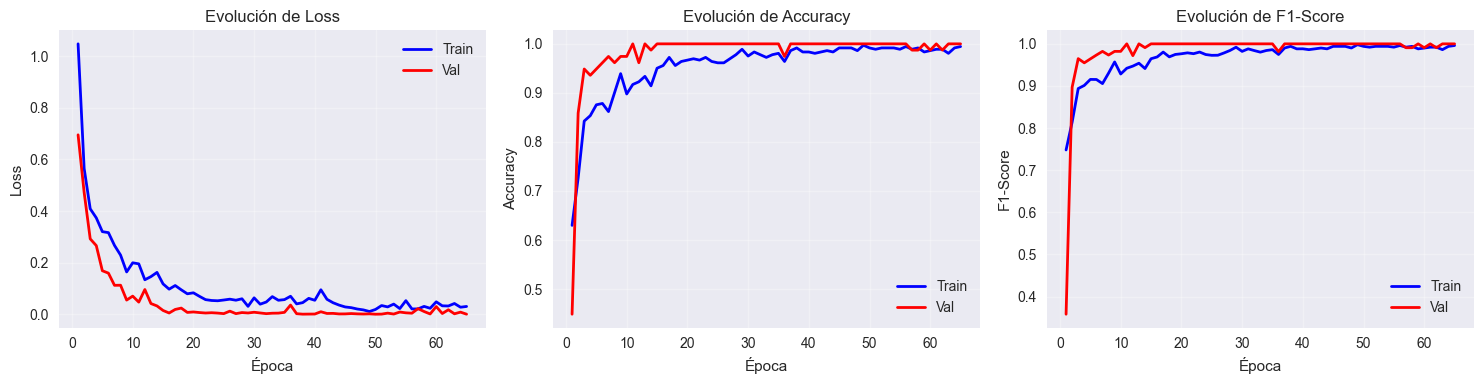


Gráfica de progreso guardada en: results\cnn_no_da\training_progress.png


In [ ]:
# ============================================================
# VISUALIZACIÓN: PROGRESO DE ENTRENAMIENTO
# ============================================================

print("="*70)
print("VISUALIZACIÓN")
print("="*70)

# Graficar progreso del entrenamiento
fig_progress = plot_training_history(
    history,
    save_path=save_dir / "training_progress.png"
)

print(f"\nGráfica de progreso guardada en: {save_dir / 'training_progress.png'}")


💾 Matriz guardada en: results\cnn_no_da\confusion_matrix_test.png


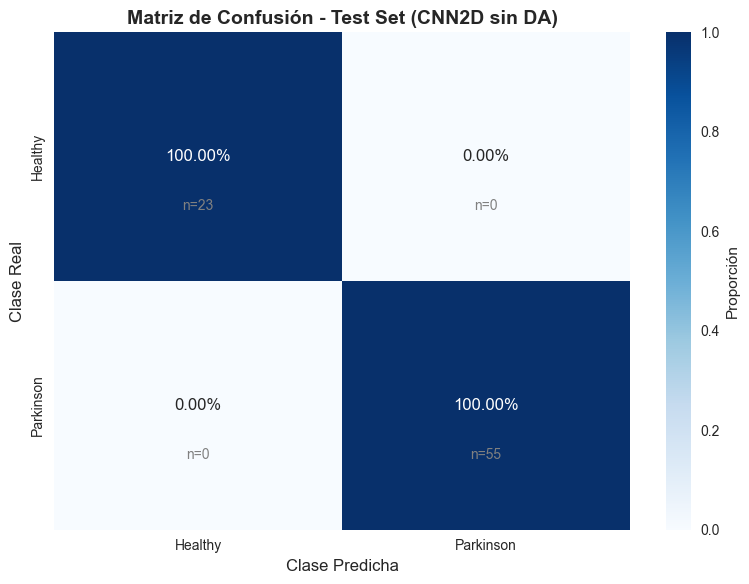


Matriz de confusión guardada en: results\cnn_no_da\confusion_matrix_test.png


In [ ]:
# ============================================================
# VISUALIZACIÓN: MATRIZ DE CONFUSIÓN
# ============================================================

cm = test_metrics["confusion_matrix"]

fig_cm = plot_confusion_matrix(
    cm,
    class_names=["Healthy", "Parkinson"],
    title="Matriz de Confusión - Test Set (CNN2D sin DA)",
    save_path=save_dir / "confusion_matrix_test.png",
    show=True
)

print(f"\nMatriz de confusión guardada en: {save_dir / 'confusion_matrix_test.png'}")


## 📋 Resumen Final

### ✅ Completado:
1. **Datos**: Cargados desde cache (augmentados)
2. **Split**: Train/Val/Test estratificado (70/15/15)
3. **Modelo**: CNN2D con mismo backbone que CNN2D_DA (sin DA)
4. **Training**: Con early stopping
5. **Evaluation**: Métricas completas en test set
6. **Visualización**: Progreso y matriz de confusión

### 🏗️ Arquitectura:
- **Feature Extractor**: 2 bloques Conv2D → BN → ReLU → MaxPool(3×3) → Dropout (igual que CNN2D_DA)
- **Solo cabeza PD**: Sin Domain Adaptation (sin GRL ni cabeza de dominio)

### 📊 Resultados Guardados:
- Modelo: `results/cnn_no_da/best_model.pth`
- Métricas: `results/cnn_no_da/test_metrics.json`
- Gráficas: `results/cnn_no_da/training_progress.png`, `confusion_matrix_test.png`

### 🔄 Comparación con CNN2D_DA:
- **Este modelo**: Mismo backbone de Ibarra pero SIN Domain Adaptation
- **CNN2D_DA** (en `cnn_da_training.ipynb`): Mismo backbone CON DA (GRL + cabeza de dominio)
- **Ventaja**: Comparación justa usando idéntico Feature Extractor

### 🚀 Próximos Pasos (Futuro):
1. **MC Dropout**: Implementar inferencia con MC Dropout para cuantificar incertidumbre
2. **Comparación**: Comparar resultados entre CNN2D y CNN2D_DA con arquitecturas equivalentes
3. **MC Dropout en DA**: Aplicar MC Dropout también a CNN2D_DA


In [ ]:
# ============================================================
# RESUMEN FINAL
# ============================================================

print("="*70)
print("RESUMEN FINAL")
print("="*70)

print(f"\nMODELO: CNN2D (sin Domain Adaptation)")
print(f"\nDATASET:")
print(f"   - Total muestras: {len(X_combined)}")
print(f"   - Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

print(f"\nMEJOR MODELO (Época {best_epoch}):")
print(f"   - Val Loss: {best_val_loss:.4f}")

print(f"\nMÉTRICAS EN TEST SET:")
report = test_metrics["classification_report"]
print(f"   - Accuracy:  {test_metrics['accuracy']:.4f}")
print(f"   - Precision: {report['macro avg']['precision']:.4f}")
print(f"   - Recall:    {report['macro avg']['recall']:.4f}")
print(f"   - F1-Score:  {test_metrics['f1_macro']:.4f}")

print(f"\nArchivos guardados en: {save_dir}")
print(f"   - best_model.pth")
print(f"   - test_metrics.json")
print(f"   - training_progress.png")
print(f"   - confusion_matrix_test.png")

print("="*70)
print("PIPELINE COMPLETADO EXITOSAMENTE")
print("="*70)


RESUMEN FINAL

MODELO: CNN2D (sin Domain Adaptation)

DATASET:
   - Total muestras: 518
   - Train: 362 | Val: 78 | Test: 78

MEJOR MODELO (Época 50):
   - Val Loss: 0.0001

MÉTRICAS EN TEST SET:
   - Accuracy:  1.0000
   - Precision: 1.0000
   - Recall:    1.0000
   - F1-Score:  1.0000

Archivos guardados en: results\cnn_no_da
   - best_model.pth
   - test_metrics.json
   - training_progress.png
   - confusion_matrix_test.png
PIPELINE COMPLETADO EXITOSAMENTE
